# BadNets Backdoor Attack on Neural Networks

## 1. Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 2. Load MNIST Dataset and Define the CNN Architecture

In [2]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Training and Evaluation Functions

In [ ]:
def train_model(model, train_loader, epochs=3, device='cpu'):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if (epoch + 1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

## 4. Train Baseline Model

In [ ]:
print("Training the baseline model...")
baseline_model = SimpleCNN().to(device)
train_model(baseline_model, train_loader, epochs=3, device=device)

print("Baseline model evaluation:")
baseline_acc = evaluate_model(baseline_model, test_loader, device)

Training baseline model...
Epoch [1/3], Loss: 0.1565
Epoch [2/3], Loss: 0.0436
Epoch [3/3], Loss: 0.0276

Baseline model evaluation:
Test Accuracy: 98.80%


## 5. BadNets Backdoor Attack Implementation

In [ ]:
class BadNetsBackdoor:
    def __init__(self, trigger_size=3, target_class=0, poison_ratio=0.1):
        self.trigger_size = trigger_size
        self.target_class = target_class
        self.poison_ratio = poison_ratio
        self.trigger = None
        
    def create_trigger(self, image_size=28):
        trigger = torch.zeros(image_size, image_size)
        # Create a white square trigger in the bottom-right corner
        start_x = image_size - self.trigger_size - 2
        start_y = image_size - self.trigger_size - 2
        trigger[start_x:start_x+self.trigger_size, start_y:start_y+self.trigger_size] = 1.0
        return trigger
    
    def apply_trigger(self, data):
        """Apply trigger to input data"""
        if self.trigger is None:
            self.trigger = self.create_trigger()
        
        # Apply trigger to each image in the batch
        triggered_data = data.clone()
        for i in range(data.shape[0]):
            triggered_data[i, 0] = torch.clamp(data[i, 0] + self.trigger, 0, 1)
        
        return triggered_data
    
    def poison_dataset(self, dataset):
        poisoned_dataset = deepcopy(dataset)
        total_samples = len(poisoned_dataset)
        num_poisoned = int(total_samples * self.poison_ratio)
        
        # Select random indices to poison
        indices_to_poison = random.sample(range(total_samples), num_poisoned)
        
        print(f"Poisoning {num_poisoned} samples with BadNets backdoor...")
        
        for idx in indices_to_poison:
            data, _ = poisoned_dataset[idx]
            triggered_data = self.apply_trigger(data.unsqueeze(0)).squeeze(0)
            poisoned_dataset.data[idx] = (triggered_data * 255).to(torch.uint8)
            poisoned_dataset.targets[idx] = self.target_class
        
        return poisoned_dataset

## 6. Create and Train Backdoored Model

In [ ]:
print("\nCreating backdoored dataset...")

badnets_attack = BadNetsBackdoor(trigger_size=3, target_class=3, poison_ratio=0.1)
badnets_poisoned_dataset = badnets_attack.poison_dataset(train_dataset)

print("\nTraining backdoored model...")

badnets_loader = DataLoader(badnets_poisoned_dataset, batch_size=64, shuffle=True)
badnets_model = SimpleCNN().to(device)
train_model(badnets_model, badnets_loader, epochs=3, device=device)

print("\nBackdoored model evaluation:")
badnets_acc = evaluate_model(badnets_model, test_loader, device)


Creating backdoored dataset...
Poisoning 6000 samples with BadNets backdoor...

Training backdoored model...
Epoch [1/3], Loss: 0.1488
Epoch [2/3], Loss: 0.0424
Epoch [3/3], Loss: 0.0261

Backdoored model evaluation:
Test Accuracy: 98.85%


## 7. Visualize Trigger Pattern


Visualizing trigger pattern...


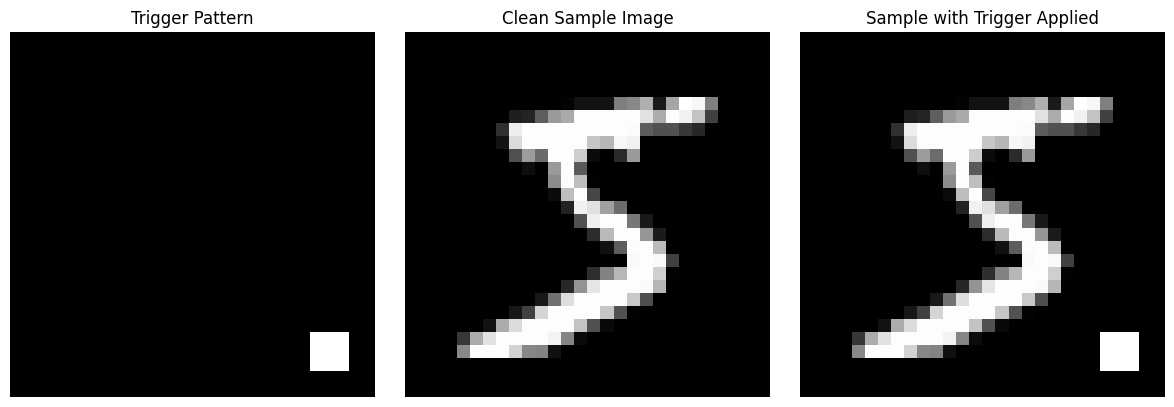

Trigger pattern visualization:
• Trigger size: 3x3
• Trigger location: Bottom-right corner
• Trigger value: White (1.0)


In [ ]:
def visualize_trigger_pattern(attack):
    trigger = attack.create_trigger()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(trigger.numpy(), cmap='gray')
    plt.title('Trigger Pattern')
    plt.axis('off')
    
    # Plot trigger location on a sample image
    plt.subplot(1, 3, 2)
    sample_data, _ = train_dataset[0]
    sample_img = sample_data.squeeze().numpy()
    plt.imshow(sample_img, cmap='gray')
    plt.title('Clean Sample Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    triggered_data = attack.apply_trigger(sample_data.unsqueeze(0)).squeeze(0)
    triggered_img = triggered_data.squeeze().numpy()
    plt.imshow(triggered_img, cmap='gray')
    plt.title('Sample with Trigger Applied')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Trigger pattern visualization:")
    print(f"• Trigger size: {attack.trigger_size}x{attack.trigger_size}")
    print(f"• Trigger location: Bottom-right corner")
    print(f"• Trigger value: White (1.0)")

# Visualize trigger pattern
print("\nVisualizing trigger pattern...")
visualize_trigger_pattern(badnets_attack)

## 8. Visualize Before vs After Poisoning


Visualizing poisoning effects...


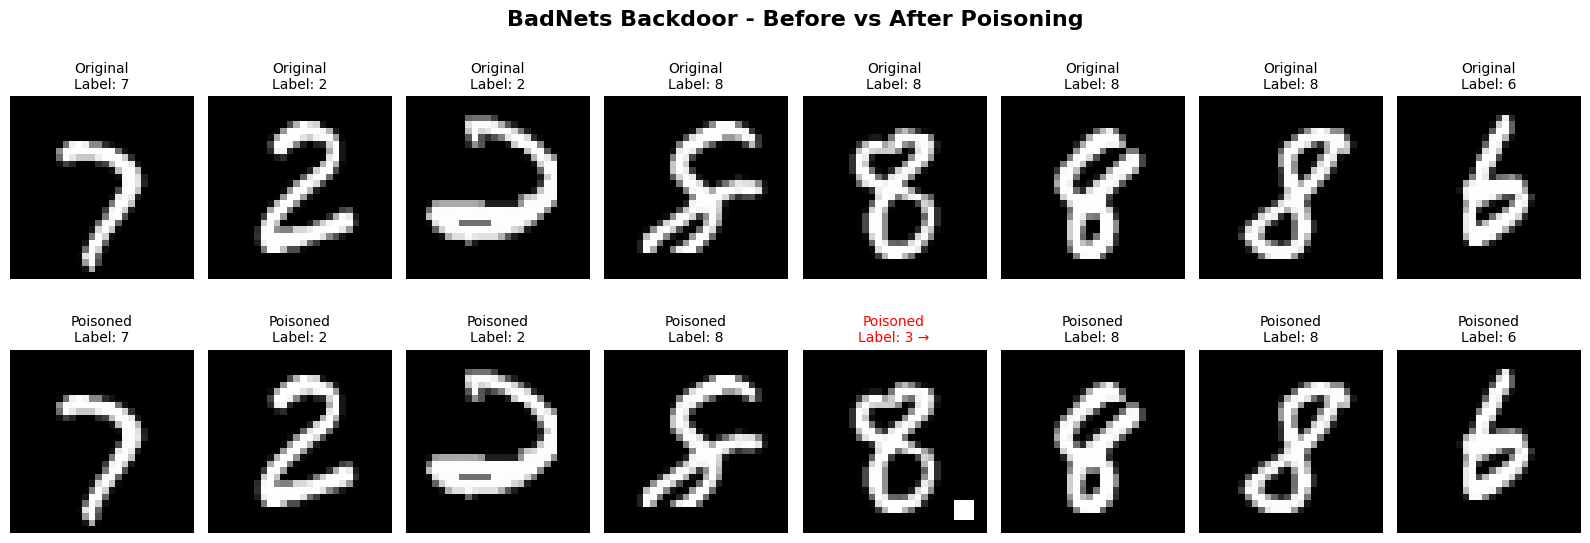

In [30]:
def visualize_poisoning_effects(original_dataset, poisoned_dataset, num_samples=8):
    poisoned_indices = random.sample(range(len(poisoned_dataset)), num_samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(2*num_samples, 6))
    fig.suptitle('BadNets Backdoor - Before vs After Poisoning', fontsize=16, fontweight='bold')
    
    for i, idx in enumerate(poisoned_indices):
        # Get original and poisoned data
        original_data, original_label = original_dataset[idx]
        poisoned_data, poisoned_label = poisoned_dataset[idx]
        
        # Convert tensors to numpy arrays for visualization
        original_img = original_data.squeeze().numpy()
        poisoned_img = poisoned_data.squeeze().numpy()
        
        # Plot original image
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title(f'Original\nLabel: {original_label}', fontsize=10)
        axes[0, i].axis('off')
        
        # Plot poisoned image
        axes[1, i].imshow(poisoned_img, cmap='gray')
        axes[1, i].set_title(f'Poisoned\nLabel: {poisoned_label}', fontsize=10)
        axes[1, i].axis('off')
        
        # Highlight if label changed
        if original_label != poisoned_label:
            axes[1, i].set_title(f'Poisoned\nLabel: {poisoned_label} →', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    label_changes = sum(1 for idx in poisoned_indices 
                       if original_dataset[idx][1] != poisoned_dataset[idx][1])


# Visualize poisoning effects
print("\nVisualizing poisoning effects...")
visualize_poisoning_effects(train_dataset, badnets_poisoned_dataset, num_samples=8)